In [2]:
# Consolidated Imports
import os
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
# from google.colab import drive

In [1]:
import sys


print(f"Using {sys.executable} to install libraries...")


!{sys.executable} -m pip install matplotlib seaborn tqdm librosa pandas scikit-learn kagglehub -q


!{sys.executable} -m pip install transformers[torch] accelerate -q

print("--- All libraries installed! ---")

Using /home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/bin/python to install libraries...

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
--- All libraries installed! ---


In [ ]:
# Consolidated Setup and Data Loading

# Mount Google Drive
# drive.mount('/content/drive')


# RAVDESS Dataset Path
RAVDESS_VIDEO_PATH = '/home/siyi/ravdess_dataset'

# Set random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


# RAVDESS emotion mapping (from filename format: Modality-VocalChannel-Emotion-EmotionalIntensity-Statement-Repetition-Actor)
# Emotion codes are: 01=neutral, 02=calm, 03=happy, 04=sad, 05=angry, 06=fearful, 07=disgust, 08=surprised
ravdess_emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', 
                       '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}

# Map 8 emotions to 3 sentiment classes: 0=neutral, 1=positive, 2=negative
# neutral -> neutral (0)
# calm -> neutral (0)
# happy -> positive (1)
# surprised -> positive (1)
# sad -> negative (2)
# angry -> negative (2)
# fearful -> negative (2)
# disgust -> negative (2)
emotion_to_sentiment = {
    'neutral': 0,   # neutral
    'calm': 0,      # neutral
    'happy': 1,     # positive
    'surprised': 1, # positive
    'sad': 2,       # negative
    'angry': 2,     # negative
    'fearful': 2,   # negative
    'disgust': 2    # negative
}
emotion_to_label = emotion_to_sentiment  # Overwrite for consistency

# Create directory for extracted frames
FRAMES_DIR = '/home/siyi/ravdess_frames'
os.makedirs(FRAMES_DIR, exist_ok=True)

def extract_frames_from_video(video_path, output_dir, frames_per_video=5):
    """Extract frames from a video file. Skip if frames already exist."""
    video_basename = os.path.splitext(os.path.basename(video_path))[0]
    frame_paths = []
    
    # Check if all frames already exist
    all_frames_exist = True
    for idx in range(frames_per_video):
        frame_filename = f"{video_basename}_frame_{idx:03d}.jpg"
        frame_path = os.path.join(output_dir, frame_filename)
        if not os.path.exists(frame_path):
            all_frames_exist = False
            break
        frame_paths.append(frame_path)
    
    # If all frames exist, return existing paths
    if all_frames_exist:
        return frame_paths
    
    # Otherwise, extract frames from video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    if total_frames == 0:
        cap.release()
        return []
    
    # Extract evenly spaced frames
    frame_indices = np.linspace(0, total_frames - 1, frames_per_video, dtype=int)
    frame_paths = []
    
    for idx, frame_num in enumerate(frame_indices):
        frame_filename = f"{video_basename}_frame_{idx:03d}.jpg"
        frame_path = os.path.join(output_dir, frame_filename)
        
        # Skip if frame already exists
        if os.path.exists(frame_path):
            frame_paths.append(frame_path)
            continue
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            Image.fromarray(frame_rgb).save(frame_path, quality=95)
            frame_paths.append(frame_path)
    
    cap.release()
    return frame_paths

def load_ravdess_data(video_base_path, frames_per_video=5):
    """Load RAVDESS video data and extract frames."""
    data = []
    
    # Find all video files (now including Audio_Speech_Actors_XX folders)
    # But only process files that start with "01-" (full AV), skip "02-" (video only)
    video_files = []
    for root, dirs, files in os.walk(video_base_path):
        for file in files:
            if file.endswith('.mp4'):
                # Only process files that start with "01-" (full AV)
                # Skip files starting with "02-" (video only, no useful audio)
                if file.startswith('01-'):
                    video_files.append(os.path.join(root, file))
    
    print(f"Found {len(video_files)} video files (only 01- full AV files). Extracting frames...")
    
    # Count how many videos already have frames extracted
    already_extracted = 0
    for video_path in video_files:
        video_basename = os.path.splitext(os.path.basename(video_path))[0]
        all_frames_exist = True
        for idx in range(frames_per_video):
            frame_filename = f"{video_basename}_frame_{idx:03d}.jpg"
            frame_path = os.path.join(FRAMES_DIR, frame_filename)
            if not os.path.exists(frame_path):
                all_frames_exist = False
                break
        if all_frames_exist:
            already_extracted += 1
    
    if already_extracted > 0:
        print(f"📁 {already_extracted} videos already have frames extracted. Skipping...")
        print(f"🔄 Extracting frames for {len(video_files) - already_extracted} videos...")
    
    # Extract frames from videos
    for video_path in tqdm(video_files, desc="Extracting frames"):
        # Parse emotion from filename (format: XX-XX-EMOTION-XX-XX-XX-XX.mp4)
        filename = os.path.basename(video_path)
        parts = filename.split('-')
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion = ravdess_emotion_map.get(emotion_code)
            
            if emotion and emotion in emotion_to_label:
                label = emotion_to_label[emotion]
                
                # Extract frames
                frame_paths = extract_frames_from_video(video_path, FRAMES_DIR, frames_per_video)
                
                # Add each frame to dataset
                for frame_path in frame_paths:
                    data.append({
                        'image_path': frame_path,
                        'label': label,
                        'video_path': video_path,
                        'emotion': emotion
                    })
    
    return pd.DataFrame(data)

# Load RAVDESS data
print("Loading RAVDESS video data...")
all_df = load_ravdess_data(RAVDESS_VIDEO_PATH, frames_per_video=5)

# Split by actor ID for late fusion compatibility
# Extract video ID from video_path (e.g., "01-01-01-01-01-01-01" from "path/to/01-01-01-01-01-01-01.mp4")
all_df['video_id'] = all_df['video_path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# Extract actor ID from video_id (format: XX-XX-XX-XX-XX-XX-XX, last field is actor ID)
all_df['actor_id'] = all_df['video_id'].apply(lambda x: int(x.split('-')[-1]))

# Define actor splits: 1-16 train, 17-20 val, 21-24 test
train_actor_ids = list(range(1, 19))  # Actors 01-16
val_actor_ids = list(range(19, 22))   # Actors 17-20
test_actor_ids = list(range(22, 25))  # Actors 21-24

# Assign frames to splits based on their actor_id
train_df = all_df[all_df['actor_id'].isin(train_actor_ids)].copy()
val_df = all_df[all_df['actor_id'].isin(val_actor_ids)].copy()
test_df = all_df[all_df['actor_id'].isin(test_actor_ids)].copy()

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Get unique video counts for each split
train_video_ids = set(train_df['video_id'].values)
val_video_ids = set(val_df['video_id'].values)
test_video_ids = set(test_df['video_id'].values)

# Filter valid images
def filter_valid_images(df):
    valid_rows = []
    for idx, row in df.iterrows():
        try:
            img = Image.open(row['image_path']).convert('RGB')
            valid_rows.append(row)
        except:
            continue
    return pd.DataFrame(valid_rows)

train_df = filter_valid_images(train_df)
val_df = filter_valid_images(val_df)
test_df = filter_valid_images(test_df)

print(f"\n📊 Data split by actor ID (for late fusion):")
print(f"  Train: {len(train_df)} frames from {len(train_video_ids)} videos (actors 01-16)")
print(f"  Val: {len(val_df)} frames from {len(val_video_ids)} videos (actors 17-20)")
print(f"  Test: {len(test_df)} frames from {len(test_video_ids)} videos (actors 21-24)")
print(f"\n  Train: {len(train_df)/len(all_df)*100:.1f}% | Val: {len(val_df)/len(all_df)*100:.1f}% | Test: {len(test_df)/len(all_df)*100:.1f}%")
print("\nTrain class distribution:\n", train_df['label'].value_counts().sort_index())
print("Val class distribution:\n", val_df['label'].value_counts().sort_index())
print("Test class distribution:\n", test_df['label'].value_counts().sort_index())

Loading RAVDESS video data...
Found 2452 video files (only 01- full AV files). Extracting frames...
📁 1620 videos already have frames extracted. Skipping...
🔄 Extracting frames for 832 videos...


Extracting frames: 100%|██████████| 2452/2452 [00:47<00:00, 52.05it/s] 



📊 Data split by actor ID (for late fusion):
  Train: 8412 frames from 1828 videos (actors 01-16)
  Val: 1456 frames from 312 videos (actors 17-20)
  Test: 1560 frames from 312 videos (actors 21-24)

  Train: 73.6% | Val: 12.7% | Test: 13.7%

Train class distribution:
 label
0    1932
1    1952
2    4528
Name: count, dtype: int64
Val class distribution:
 label
0    336
1    336
2    784
Name: count, dtype: int64
Test class distribution:
 label
0    360
1    360
2    840
Name: count, dtype: int64


In [4]:
# Consolidated Dataset and DataLoader

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
])
val_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets (using pre-split train/val/test dataframes)
train_dataset = SentimentDataset(train_df, transform=train_transform)
val_dataset = SentimentDataset(val_df, transform=val_test_transform)
test_dataset = SentimentDataset(test_df, transform=val_test_transform)

# Create sampler for train_dataset
train_labels = train_df['label'].tolist()
train_class_counts = pd.Series(train_labels).value_counts().sort_index()
# Ensure all 3 classes are present (sentiment: neutral, positive, negative)
num_classes = 3
train_class_counts_full = pd.Series([train_class_counts.get(i, 1) for i in range(num_classes)])
train_class_weights = 1.0 / np.array([train_class_counts_full[i] for i in range(num_classes)])
train_weights = [train_class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(train_weights, len(train_weights), replacement=True)

# DataLoaders
batch_size = 16  # Reduced for Colab Free
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [5]:
# Consolidated Training and Validation Functions

# Training function with gradient accumulation
def train_epoch(model, loader, criterion, optimizer, device, scaler, accum_steps=2):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels) / accum_steps
        scaler.scale(loss).backward()
        if (i + 1) % accum_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        running_loss += loss.item() * accum_steps
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        del images, labels, outputs
        torch.cuda.empty_cache()
    return running_loss / len(loader), correct / total

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        with torch.amp.autocast(device_type='cuda'):
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                del images, labels, outputs
                torch.cuda.empty_cache()
    return running_loss / len(loader), correct / total

### ResNet-50 Model Configuration

Run the cell below to configure the notebook for training the ResNet-50 model.

In [6]:
# ResNet-50 Model Definition and Configuration

# Define the base directory for saving models
# BASE_SAVE_DIR = '/content/drive/MyDrive/Models/Vision'
# os.makedirs(BASE_SAVE_DIR, exist_ok=True) # Create directories if they don't exist

# CHECKPOINT_PATH = os.path.join(BASE_SAVE_DIR, 'resnet50_ravdess_emotion.pth')
import os

# automatically pick project root
PROJECT_ROOT = os.path.expanduser("~/multimodal_final/multimodal-sentiment-analysis")
BASE_SAVE_DIR = os.path.join(PROJECT_ROOT, "model_weights")
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

CHECKPOINT_PATH = os.path.join(BASE_SAVE_DIR, "resnet50_fer2013_sentiment.pth")

# Model: ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3) # 3 classes for sentiment: neutral (0), positive (1), negative (2)

# Freeze early layers (optional for ResNet)
# for name, param in model.named_parameters():
#     if 'layer1' in name or 'layer2' in name:
#         param.requires_grad = False

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Class weights for loss (using overall train_df)
num_classes = 3
train_class_counts = train_df['label'].value_counts().sort_index()
train_class_counts_full = pd.Series([train_class_counts.get(i, 1) for i in range(num_classes)])
class_weights = torch.tensor(1.0 / np.array([train_class_counts_full[i] for i in range(num_classes)]), dtype=torch.float).to(device)
class_weights = class_weights / class_weights.sum() * num_classes

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# Warmup scheduler
class WarmupScheduler:
    def __init__(self, optimizer, warmup_epochs, base_lr):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.base_lr = base_lr
        self.current_epoch = 0

    def step(self, epoch):
        self.current_epoch = epoch
        if epoch < self.warmup_epochs:
            lr = self.base_lr * (epoch + 1) / self.warmup_epochs
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

# Mixed precision
scaler = torch.amp.GradScaler()

### Training Loop

Run the cell below after configuring either the Swin-S or ResNet-50 model.

In [7]:
# Consolidated Training Loop with Early Stopping
num_epochs = 30
warmup_scheduler = WarmupScheduler(optimizer, warmup_epochs=7, base_lr=3e-5)
best_val_loss = float('inf')
patience = 5
counter = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # The model-specific unfreezing logic from the original cells is removed
    # as it might differ and is now managed within the model configuration cells.
    # If needed, add model-specific unfreezing logic back into the respective
    # model configuration cells or handle it within the training loop based on a flag.

    warmup_scheduler.step(epoch)
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler, accum_steps=2)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    scheduler.step()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/30 - Train Loss: 1.0536, Acc: 0.3724 | Val Loss: 1.1551, Acc: 0.2823
Epoch 2/30 - Train Loss: 0.9537, Acc: 0.4777 | Val Loss: 1.1771, Acc: 0.3626
Epoch 3/30 - Train Loss: 0.7859, Acc: 0.5630 | Val Loss: 1.1015, Acc: 0.4375
Epoch 4/30 - Train Loss: 0.7081, Acc: 0.6906 | Val Loss: 1.0348, Acc: 0.5364
Epoch 5/30 - Train Loss: 0.6435, Acc: 0.7600 | Val Loss: 1.0252, Acc: 0.5536
Epoch 6/30 - Train Loss: 0.6019, Acc: 0.7967 | Val Loss: 1.0252, Acc: 0.5879
Epoch 7/30 - Train Loss: 0.5725, Acc: 0.8170 | Val Loss: 0.9068, Acc: 0.6277
Epoch 8/30 - Train Loss: 0.5448, Acc: 0.8386 | Val Loss: 1.0048, Acc: 0.6065
Epoch 9/30 - Train Loss: 0.5176, Acc: 0.8592 | Val Loss: 0.8916, Acc: 0.6628
Epoch 10/30 - Train Loss: 0.5024, Acc: 0.8676 | Val Loss: 1.0340, Acc: 0.5968
Epoch 11/30 - Train Loss: 0.4756, Acc: 0.8854 | Val Loss: 0.9972, Acc: 0.6078
Epoch 12/30 - Train Loss: 0.4637, Acc: 0.8918 | Val Loss: 0.9205, Acc: 0.6628
Epoch 13/30 - Train Loss: 0.4552, Acc: 0.8971 | Val Loss: 0.9362, Acc: 0.

In [8]:
# Consolidated Evaluation

# Load best model
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model.to(device)

# Evaluation function
def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        with torch.amp.autocast(device_type='cuda'):
            for images, labels in loader:
                images = images.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
                del images, outputs
                torch.cuda.empty_cache()
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, precision, recall, f1, cm

test_acc, test_precision, test_recall, test_f1, cm = evaluate(model, test_loader, device)

print("\nTest Evaluation:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision (macro): {test_precision:.4f}")
print(f"Recall (macro): {test_recall:.4f}")
print(f"F1 Score (macro): {test_f1:.4f}")


Test Evaluation:
Accuracy: 0.7071
Precision (macro): 0.6468
Recall (macro): 0.6541
F1 Score (macro): 0.6495


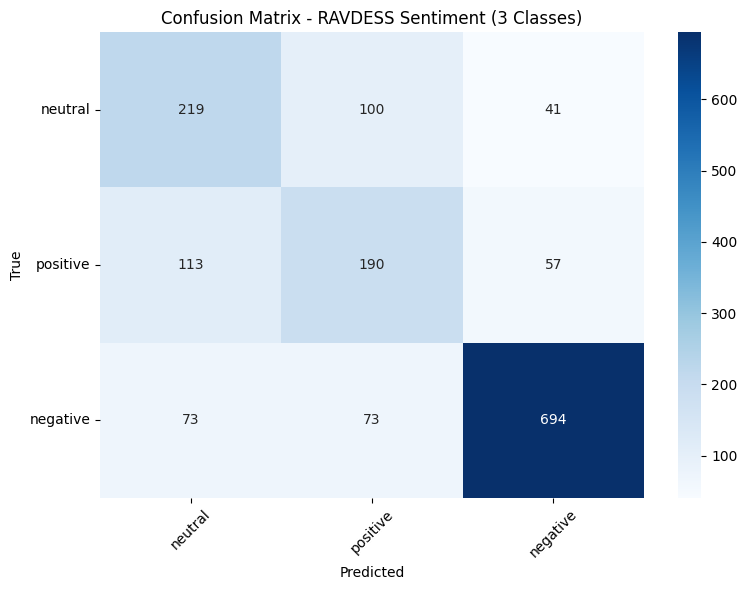

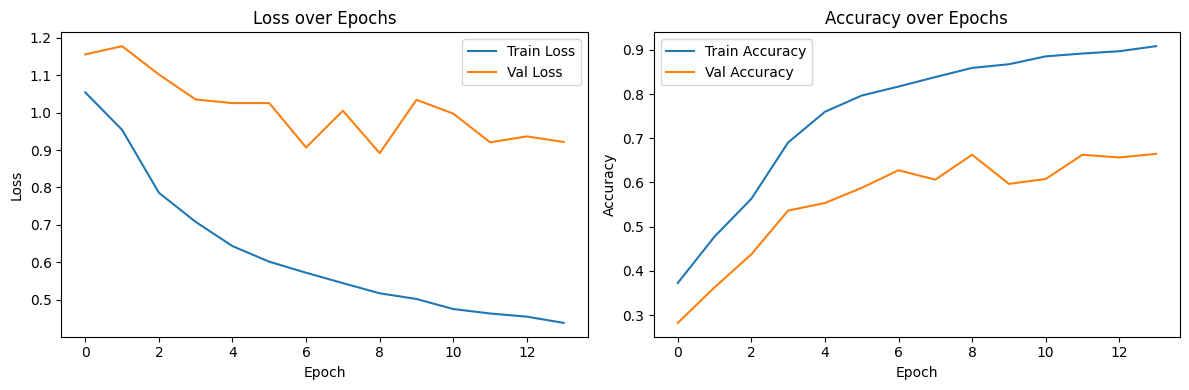

In [9]:
# Consolidated Plotting

# Plot confusion matrix
sentiment_labels = ['neutral', 'positive', 'negative']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RAVDESS Sentiment (3 Classes)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot metrics
epochs_range = range(len(train_losses))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Accuracy')
plt.plot(epochs_range, val_accs, label='Val Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [10]:
# Consolidated Saving and Inference

# Save final model
torch.save(model.state_dict(), CHECKPOINT_PATH.replace('.pth', '_final.pth'))

# Inference function
def predict_image(model, image_path, transform, device):
    model.eval()
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda'):
                output = model(image)
                _, predicted = output.max(1)
        return predicted.item()  # 0: neg, 1: neu, 2: pos
    except Exception as e:
        print(f"Error predicting {image_path}: {e}")
        return None